In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import glob
from tqdm import tqdm
import itertools

# Collecting stats

In [2]:
with open("/root/data/smartwatch/subjects_2023-06-27/valid_files.txt") as f:
    valid_files = f.readlines()
    valid_files = [x.strip() for x in valid_files]

In [3]:
mocap_files = ["/root/data/smartwatch/subjects_2023-06-27/" + file + "_mocap.csv" for file in valid_files]

# Testing generating wrist position and orientation features

In [4]:
fp = mocap_files[0]
df = df_mocap = pd.read_csv(fp, skiprows=2)

$O_w = p_{US}$

$p_{elb} = p_{ME} - p_{LE}$

$Y_w = p_{elb} - p_{US}$

$v_1 = p_{RS} - p_{US}$

$X_w = Y_w \times v_1$  $\rarr$ This is "up" by RHR

$Z_w = X_w \times Y_w$  $\rarr$ This is "right" by RHR

In [5]:
subject = "S01"
col_inds = []
markers = ["R_RS", "R_US", "R_ME", "R_LE"]
for loc in markers:
    i = df.columns.tolist().index(f"{subject}_cal:{loc}")
    col_inds.extend([i, i+1, i+2])
subdf = df.iloc[2:, col_inds]
subdf.columns = [f"{loc}_{axis}" for loc, axis in itertools.product(markers, "XYZ")]
subdf = subdf.astype(float)

In [6]:
subdf

R_RS_X    R_RS_Y   R_RS_Z   R_US_X    R_US_Y   R_US_Z   R_ME_X  \
2     529.912  -35.6970  513.395  475.035  -33.4067  497.155  463.057   
3     520.554  -34.1914  514.183  465.425  -31.5752  498.710  457.365   
4     511.087  -32.3205  514.870  455.807  -29.2905  500.122  451.786   
5     501.572  -29.9874  515.380  446.143  -26.6057  501.424  445.752   
6     492.116  -27.2087  515.755  436.514  -23.4621  502.597  440.171   
...       ...       ...      ...      ...       ...      ...      ...   
2852  243.076  190.5240  475.551  198.086  223.0560  492.494  380.939   
2853  238.372  179.4000  481.615  192.979  212.0950  498.211  377.249   
2854  234.475  168.1040  487.468  189.041  200.9390  503.684  373.794   
2855  231.380  156.7610  493.095  185.852  189.6150  508.874  370.602   
2856  229.133  145.3030  498.481  183.401  178.1780  513.759  367.947   

       R_ME_Y   R_ME_Z   R_LE_X   R_LE_Y   R_LE_Z  
2     173.086  686.275  422.443  103.049  712.226  
3     174.971  687.853  416.700  105.272  714.369  
4     177.068  689.335  410.880  107.722  716.464  
5     179.689  691.066  405.104  110.393  718.470  
6     182.267  692.549  399.373  113.309  720.413  
...       ...      ...      ...      ...      ...  
2852  325.235  675.788  315.051  285.541  712.410  
2853  319.472  677.868  312.030  279.982  715.685  
2854  313.686  679.750  309.354  274.189  718.717  
2855  307.647  681.317  307.020  268.242  721.546  
2856  301.409  682.870  305.042  262.114  724.129  

[2855 rows x 12 columns]

In [7]:
p_rs = subdf.iloc[2, [0, 1, 2]].values
p_us = subdf.iloc[2, [3, 4, 5]].values
p_me = subdf.iloc[2, [6, 7, 8]].values
p_le = subdf.iloc[2, [9, 10, 11]].values

In [8]:
p_rs, p_us

(array([511.087 , -32.3205, 514.87  ]), array([455.807 , -29.2905, 500.122 ]))

In [9]:
np.vstack([p_rs, p_us])[:, 0]

array([511.087, 455.807])

In [10]:
o_w = p_us
p_elbow = (p_le + p_me) / 2

y_w = p_elbow - p_us
v_1 = p_rs - p_us
x_w = np.cross(y_w, v_1)
z_w = np.cross(x_w, y_w)

# Unit axis vectors
e_x = x_w / np.linalg.norm(x_w)
e_y = y_w / np.linalg.norm(y_w)
e_z = z_w / np.linalg.norm(z_w)

# Rotation matrix
R = np.vstack([
    e_x,
    e_y,
    e_z
])

In [11]:
R

array([[ 0.20637396,  0.75890569, -0.61763414],
       [-0.09172431,  0.64344752,  0.75997496],
       [ 0.97416448, -0.10018697,  0.20240092]])

In [12]:
x_w / np.linalg.norm(x_w)

array([ 0.20637396,  0.75890569, -0.61763414])

In [13]:
a = np.eye(3)
R @ a

array([[ 0.20637396,  0.75890569, -0.61763414],
       [-0.09172431,  0.64344752,  0.75997496],
       [ 0.97416448, -0.10018697,  0.20240092]])

In [14]:
def plot_line(ax, coords, c='k', **kwargs):
    ax.plot(coords[:, 0], coords[:, 1], zs=coords[:, 2], c=c, **kwargs)
    return ax

def plot_point(ax, point, **kwargs):
    ax.scatter(point[0], point[1], zs=point[2], **kwargs)
    return ax

In [15]:
# %matplotlib widget

In [16]:
basis = np.eye(3)
new_basis = R @ basis

origin = np.array([500, 100, 500])

old_axes = np.vstack([origin] * 3)
old_axes = old_axes + basis * 50

new_axes = np.vstack([origin] * 3)
new_axes = new_axes + new_basis * 50

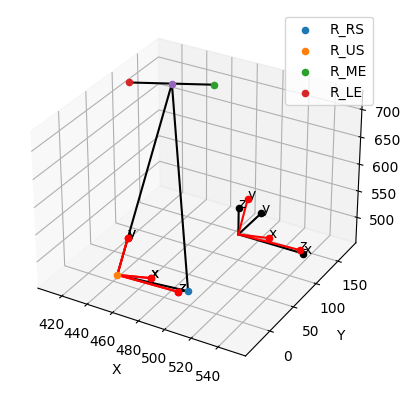

In [17]:
ax = plt.figure().add_subplot(projection='3d')

for point, label in zip([p_rs, p_us, p_me, p_le], markers):
    x, y, z = point
    ax.scatter(x, y, zs=z, label=label)

# Elbow midpoints
ax = plot_point(ax, p_elbow)
ax = plot_line(ax, np.vstack([p_le, p_me]))

# Triangle between elbow midpiont and wrist
coords = np.vstack([o_w, o_w + y_w, p_rs, o_w])
ax = plot_line(ax, coords)

# Plot local coordinate system
for unit_vec, name in zip([e_x, e_y, e_z], ["x", "y", "z"]):
    ax = plot_line(ax, np.vstack([o_w, o_w + unit_vec * 50]), c='r')
    ax = plot_point(ax, o_w + unit_vec * 50, c='r')
    ax.text(*(o_w + unit_vec * 50), name)

# Plot rotated bases
for unit_vec, name in zip([e_x, e_y, e_z], ["x", "y", "z"]):
    ax = plot_line(ax, np.vstack([o_w, o_w + unit_vec * 50]), c='r')
    ax = plot_point(ax, o_w + unit_vec * 50, c='r')
    ax.text(*(o_w + unit_vec * 50), name)

# Old axes
for i, name in enumerate(["x", "y", "z"]):
    ax = plot_line(ax, np.vstack([origin, old_axes[i, :]]), c='k')
    ax = plot_point(ax, old_axes[i, :], c='k')
    ax.text(*(old_axes[i, :]), name)

# Rotated axes
for i, name in enumerate(["x", "y", "z"]):
    ax = plot_line(ax, np.vstack([origin, new_axes[i, :]]), c='r')
    ax = plot_point(ax, new_axes[i, :], c='r')
    ax.text(*(new_axes[i, :]), name)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.legend()
plt.show()

In [18]:
from scipy.spatial.transform import Rotation

rot = Rotation.from_matrix(R)

In [19]:
rot.as_quat()

array([-0.30021889, -0.55557912, -0.296892  ,  0.716279  ])

In [20]:
df = subdf.iloc[1:10, :]

In [21]:
df

R_RS_X   R_RS_Y   R_RS_Z   R_US_X    R_US_Y   R_US_Z   R_ME_X   R_ME_Y  \
3   520.554 -34.1914  514.183  465.425 -31.57520  498.710  457.365  174.971   
4   511.087 -32.3205  514.870  455.807 -29.29050  500.122  451.786  177.068   
5   501.572 -29.9874  515.380  446.143 -26.60570  501.424  445.752  179.689   
6   492.116 -27.2087  515.755  436.514 -23.46210  502.597  440.171  182.267   
7   482.687 -24.0149  515.966  426.932 -19.86350  503.591  434.621  185.156   
8   473.339 -20.3695  515.983  417.435 -15.82100  504.426  429.185  188.199   
9   464.123 -16.2824  515.869  408.068 -11.34030  505.150  423.768  191.550   
10  455.081 -11.7682  515.571  398.910  -6.44958  505.685  418.354  195.358   
11  446.210  -6.8650  515.124  389.956  -1.13653  506.061  413.211  198.969   

     R_ME_Z   R_LE_X   R_LE_Y   R_LE_Z  
3   687.853  416.700  105.272  714.369  
4   689.335  410.880  107.722  716.464  
5   691.066  405.104  110.393  718.470  
6   692.549  399.373  113.309  720.413  
7   694.018  393.698  116.406  722.280  
8   695.435  388.129  119.717  724.060  
9   696.754  382.685  123.199  725.774  
10  698.241  377.390  126.863  727.392  
11  699.664  372.292  130.683  728.912

In [22]:
p_rs = df.iloc[:, [0, 1, 2]].values
p_us = df.iloc[:, [3, 4, 5]].values
p_me = df.iloc[:, [6, 7, 8]].values
p_le = df.iloc[:, [9, 10, 11]].values

o_w = p_us
p_elbow = (p_le + p_me) / 2

y_w = p_elbow - p_us
v_1 = p_rs - p_us
x_w = np.cross(y_w, v_1, axis=-1)
z_w = np.cross(x_w, y_w, axis=-1)

In [23]:

# Unit axis vectors
e_x = x_w / np.linalg.norm(x_w, axis=-1).reshape(-1, 1)
e_z = z_w / np.linalg.norm(z_w, axis=-1).reshape(-1, 1)
e_y = y_w / np.linalg.norm(y_w, axis=-1).reshape(-1, 1)

# Rotation matrix
R = np.stack([
    e_x,
    e_y,
    e_z
], axis=1)

In [24]:
rot = Rotation.from_matrix(R)
rot.as_quat()

array([[-0.29598505, -0.55210401, -0.30129736,  0.71888379],
       [-0.30021889, -0.55557912, -0.296892  ,  0.716279  ],
       [-0.30423719, -0.55943687, -0.29307768,  0.71314486],
       [-0.30879547, -0.56328326, -0.28930411,  0.7096904 ],
       [-0.31377065, -0.56672406, -0.28570003,  0.70622043],
       [-0.31902796, -0.57019694, -0.28243329,  0.70237316],
       [-0.3244027 , -0.57360237, -0.27948304,  0.69830684],
       [-0.32989834, -0.57679807, -0.27695475,  0.69409447],
       [-0.33601658, -0.5795451 , -0.27472139,  0.68974524]])

In [25]:
def load_df(fp):
    # Read the header of the file to get columns and frequency info
    with open(fp, 'r') as f:
        old_line = ""
        new_line = ""
        frequency = None
        for skip_lines, new_line in enumerate(f):
            if len(old_line.split(",")) > 5:
                break  # Stop when we encounter the first very long header row
            if old_line.lower().strip() == "trajectories":
                frequency = float(new_line.split(",")[0])  # Sometimes frequency has ",hz" on the same line
            old_line = new_line
    header = old_line.split(",")
    header_markers = [col.split(':')[-1] for col in header]
    # We need radial styloid (RS), ulnar styloid (US), medial epicondyle (ME), and lateral epicondyle (LE)
    # for computing forearm orientation and positions
    markers = ["R_RS", "R_US", "R_ME", "R_LE"]
    col_names = [f"{marker}_{axis}" for marker, axis in itertools.product(markers, "XYZ")]
    col_inds = []
    for marker in markers:
        i = header_markers.index(marker)
        col_inds.extend([i, i+1, i+2])  

    # Sort by names by index, pandas usecols arg uses sorted column order
    col_inds, col_names = list(zip(*sorted(zip(col_inds, col_names))))

    df = pd.read_csv(fp, skiprows=skip_lines + 2, usecols=col_inds, names=col_names)
    df.index = pd.to_timedelta(df.index / frequency, unit="seconds")
    df = df.resample("0.02S").mean()  # Resample to 50 Hz
    return df

In [26]:
fp = "/root/data/smartwatch/subjects/S17/S17_E1_R_1_mocap.csv"
# fp = mocap_files[0]

In [27]:
df = load_df(fp)
df

R_LE_X       R_LE_Y       R_LE_Z      R_ME_X  \
0 days 00:00:00         673.662781  1241.783813  1069.920898  740.664673   
0 days 00:00:00.020000  678.498535  1249.214844  1069.529053  746.622498   
0 days 00:00:00.040000  683.709717  1256.326416  1068.771362  752.928101   
0 days 00:00:00.060000  689.243225  1263.067627  1067.651123  759.669983   
0 days 00:00:00.080000  695.031067  1269.457397  1066.176880  766.676880   
...                            ...          ...          ...         ...   
0 days 00:00:37.780000  710.868042  1093.250000   942.225891  788.429382   
0 days 00:00:37.800000  715.108765  1092.684448   939.429932  793.018433   
0 days 00:00:37.820000  719.462708  1092.541626   936.659668  797.762268   
0 days 00:00:37.840000  724.054932  1092.774170   933.933472  802.759460   
0 days 00:00:37.860000  728.771790  1093.320557   931.222595  807.797180   

                             R_ME_Y       R_ME_Z      R_US_X       R_US_Y  \
0 days 00:00:00         1262.389038  1021.680847  521.217468  1236.210693   
0 days 00:00:00.020000  1269.482422  1022.579346  528.768311  1250.685669   
0 days 00:00:00.040000  1276.272827  1023.347168  537.381165  1264.678711   
0 days 00:00:00.060000  1282.453613  1023.751404  546.884583  1278.138794   
0 days 00:00:00.080000  1288.369995  1024.007202  557.249817  1290.835327   
...                             ...          ...         ...          ...   
0 days 00:00:37.780000  1105.013550   915.557434  648.395691   971.398071   
0 days 00:00:37.800000  1105.020752   914.103638  657.481384   970.977051   
0 days 00:00:37.820000  1105.424805   912.809814  666.873291   971.158020   
0 days 00:00:37.840000  1106.280029   911.702942  676.503174   972.038574   
0 days 00:00:37.860000  1106.913940   910.503845  686.140869   973.406311   

                            R_US_Z      R_RS_X       R_RS_Y      R_RS_Z  
0 days 00:00:00         859.181335  537.666809  1184.325684  838.777527  
0 days 00:00:00.020000  856.752991  544.059814  1198.500122  835.852600  
0 days 00:00:00.040000  853.809448  551.728149  1212.507568  832.424438  
0 days 00:00:00.060000  850.356262  560.365967  1225.938354  828.508911  
0 days 00:00:00.080000  846.460449  570.020508  1238.720947  824.118652  
...                            ...         ...          ...         ...  
0 days 00:00:37.780000  722.644165  675.580200   920.947754  732.334595  
0 days 00:00:37.800000  718.517639  684.791565   920.658569  728.566162  
0 days 00:00:37.820000  714.350891  694.134827   920.981873  724.866150  
0 days 00:00:37.840000  710.185242  703.528687   921.821899  721.213989  
0 days 00:00:37.860000  706.089355  712.968445   923.217163  717.566162  

[1894 rows x 12 columns]

In [28]:
quat = rot.as_quat()
o_w - o_w.mean(axis=0)
np.hstack([quat, o_w]).shape

(9, 7)

In [29]:
def process_file(fp, force_positive=True):
    df = load_df(fp)
    df = df.dropna(axis=0)  # For stats, drop NA rows
    if len(df) == 0:
        raise ValueError("0 length dataframe")
    # Get marker positions
    p_rs = df.loc[:, ["R_RS_X", "R_RS_Y", "R_RS_Z"]].values
    p_us = df.loc[:, ["R_US_X", "R_US_Y", "R_US_Z"]].values
    p_me = df.loc[:, ["R_ME_X", "R_ME_Y", "R_ME_Z"]].values
    p_le = df.loc[:, ["R_LE_X", "R_LE_Y", "R_LE_Z"]].values
    
    # Compute landmark vectors
    o_w = p_us
    p_elbow = (p_le + p_me) / 2

    y_w = p_elbow - p_us
    v_1 = p_rs - p_us
    x_w = np.cross(y_w, v_1, axis=-1)
    z_w = np.cross(x_w, y_w, axis=-1)

    # Unit axis vectors
    e_x = x_w / np.linalg.norm(x_w, axis=-1).reshape(-1, 1)
    e_z = z_w / np.linalg.norm(z_w, axis=-1).reshape(-1, 1)
    e_y = y_w / np.linalg.norm(y_w, axis=-1).reshape(-1, 1)

    # Rotation matrix
    R = np.stack([e_x, e_y, e_z], axis=1)
    # Convert to quaternion
    rot = Rotation.from_matrix(R)
    quat = rot.as_quat()
    # Force one channel to be positive
    if force_positive:
        means = np.mean(np.abs(quat), axis=0)
        i = np.argmax(means)
        sign = np.sign(quat[:, i]).reshape(-1, 1)
        quat = quat * sign
    # Combine centered position and quaternion
    o_w = o_w - o_w.mean(axis=0)
    o_w = np.round(o_w, decimals=0)
    quat = np.round(quat, decimals=3)
    features = np.hstack([o_w, quat])
    return features

In [30]:
y = process_file(fp)
np.isnan(y).any()

False

In [31]:
missing = []
for file in tqdm(mocap_files):
    try:
        df = load_df(file)
    except:
        print(f"Error with {file}")
        missing.append(file)
        continue

100%|██████████| 1211/1211 [00:39<00:00, 30.92it/s]


In [32]:
exercise_stats = {}
global_stats = {}
missing = []
reasons = []

for file in tqdm(mocap_files):
    try:
        features = process_file(file)
    except Exception as e:
        print(f"Error with {file}")
        missing.append({file: e})
        continue
    subject = file.split("/")[5]
    exercise = file.split("/")[6].split("_")[1]

    for i, name in enumerate(["X", "Y", "Z", "qx", "qy", "qz", "qw"]):
        vals = features[:, i]
        exercise_stats.setdefault(exercise, {}).setdefault(name, Counter()).update(vals)
        global_stats.setdefault(name, Counter()).update(vals)
    exercise_stats.setdefault(exercise, {}).setdefault("num_timepoints", []).append(len(vals))


 26%|██▌       | 310/1211 [00:11<00:27, 33.00it/s]

Error with /root/data/smartwatch/subjects_2023-06-27/S11/S11_E1_R_2_mocap.csv


 47%|████▋     | 567/1211 [00:25<00:19, 33.26it/s]

Error with /root/data/smartwatch/subjects_2023-06-27/S25/S25_E6_R_1_mocap.csv


 78%|███████▊  | 939/1211 [00:42<00:08, 30.36it/s]

Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E2_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E2_R_2_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E3_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E3_R_2_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E4_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E4_R_2_mocap.csv


 78%|███████▊  | 947/1211 [00:42<00:08, 32.03it/s]

Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E5_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E5_R_2_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E6_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E6_R_2_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E7_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E7_R_2_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E8_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E8_R_2_mocap.csv


 79%|███████▉  | 955/1211 [00:42<00:07, 32.70it/s]

Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E9_R_1_mocap.csv
Error with /root/data/smartwatch/subjects_2023-06-27/S47/S47_E9_R_2_mocap.csv


100%|██████████| 1211/1211 [00:52<00:00, 23.16it/s]


In [33]:
len(missing)

18

In [34]:
# No data in these dataframes, ignore them
missing

[{'/root/data/smartwatch/subjects_2023-06-27/S11/S11_E1_R_2_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S25/S25_E6_R_1_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E2_R_1_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E2_R_2_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E3_R_1_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E3_R_2_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E4_R_1_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E4_R_2_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_2023-06-27/S47/S47_E5_R_1_mocap.csv': ValueError('0 length dataframe')},
 {'/root/data/smartwatch/subjects_202

In [50]:
# import pickle
# with open("/root/data/smartwatch/analysis/mocap_global_stats_2023-06-27.pkl", "wb") as f:
#     pickle.dump(global_stats, f)
# with open("/root/data/smartwatch/analysis/mocap_exercise_stats_2023-06-27.pkl", "wb") as f:
#     pickle.dump(exercise_stats, f)

# Visualization

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [37]:
import pickle

# with open("/root/data/smartwatch/analysis/mocap_global_stats_2023-06-27.pkl", "rb") as f:
#     global_stats = pickle.load(f)
# with open("/root/data/smartwatch/analysis/mocap_exercise_stats_2023-06-27.pkl", "rb") as f:
#     exercise_stats = pickle.load(f)

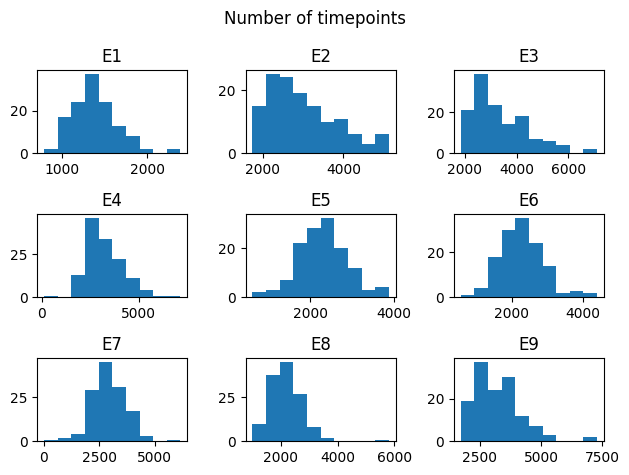

In [38]:
fig, axs = plt.subplots(3, 3)
axs = axs.flatten()
all_timepoint_data = []
for ax, (exercise, data) in zip(axs, exercise_stats.items()):
    all_timepoint_data.extend(data["num_timepoints"])
    ax.hist(data["num_timepoints"])
    ax.set_title(exercise)
plt.suptitle("Number of timepoints")
plt.tight_layout()
plt.show()

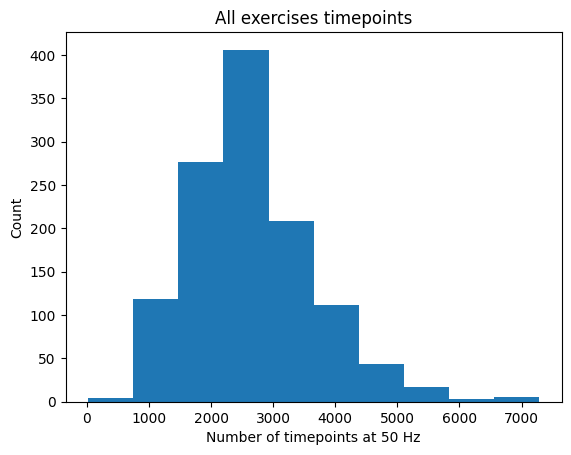

In [39]:
plt.hist(all_timepoint_data)
plt.title("All exercises timepoints")
plt.xlabel("Number of timepoints at 50 Hz")
plt.ylabel("Count")
plt.show()

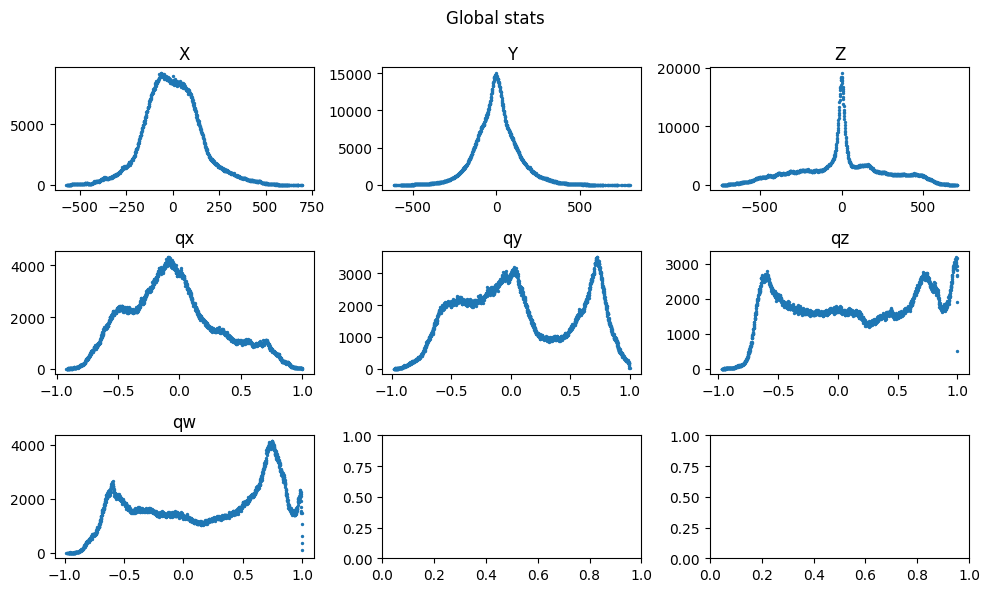

In [40]:
fig, axs = plt.subplots(3, 3, figsize=(10, 6))
axs = axs.flatten()

for ax, (channel, counter) in zip(axs, global_stats.items()):
    ax.scatter(counter.keys(), counter.values(), s=2)
    ax.set_title(channel)
plt.suptitle("Global stats")
plt.tight_layout()
plt.show()

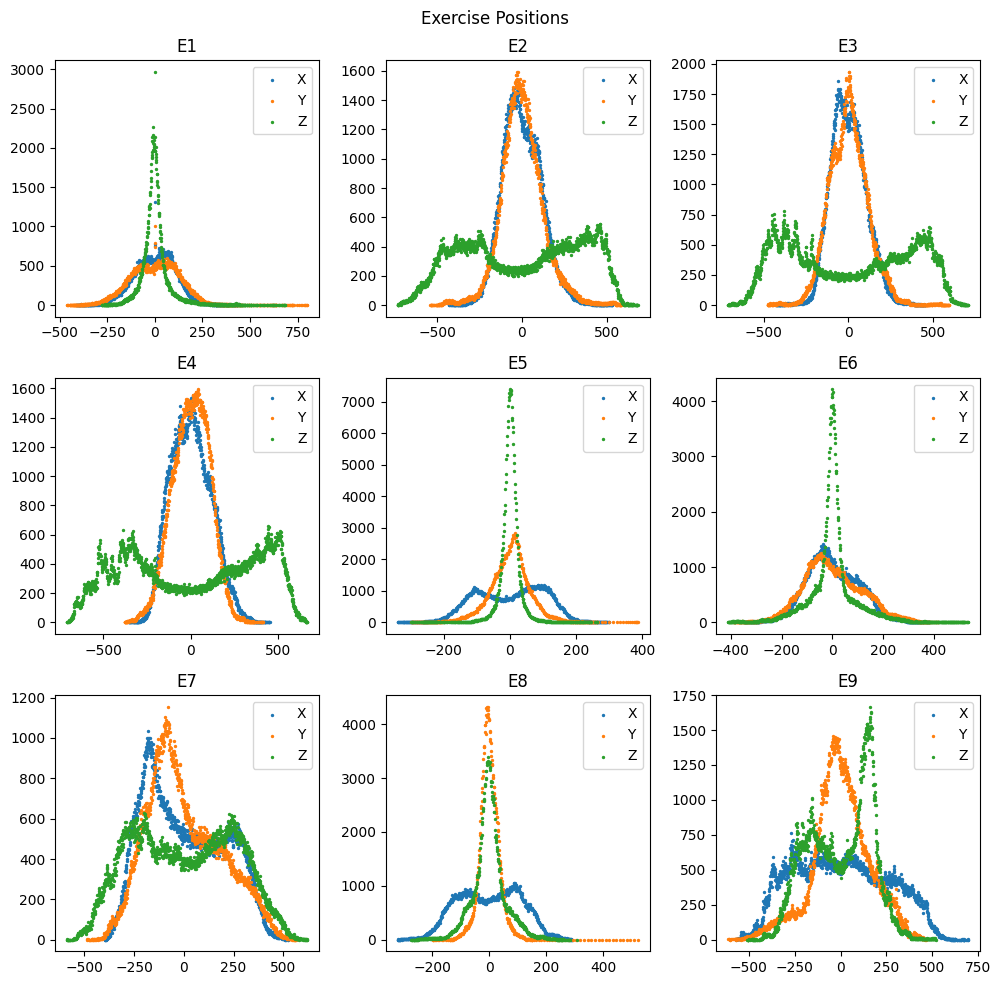

In [41]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for ax, (exercise, data) in zip(axs, exercise_stats.items()):
    for key, counter in data.items():
        if "num" in key or "q" in key:
            continue
        ax.scatter(counter.keys(), counter.values(), s=2, label=key)
    ax.set_title(exercise)
    ax.legend()
plt.suptitle("Exercise Positions")
plt.tight_layout()
plt.show()

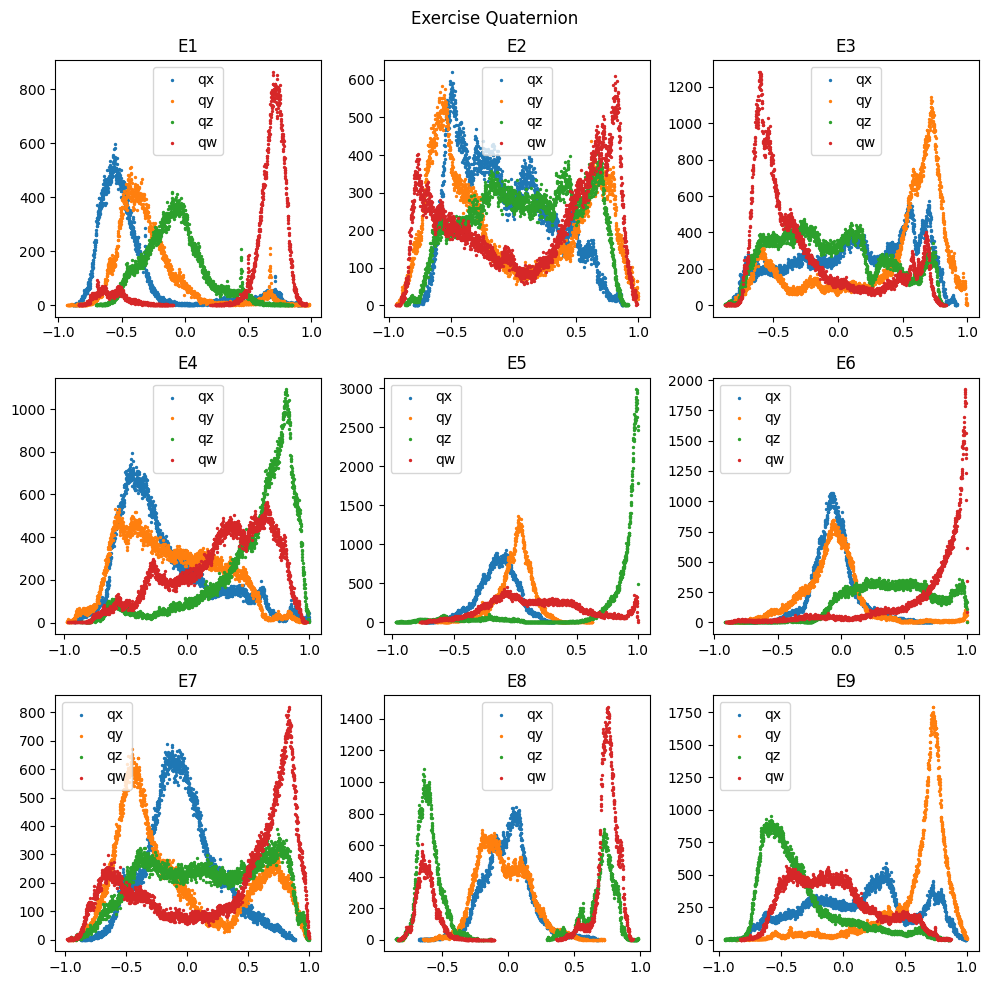

In [42]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()

for ax, (exercise, data) in zip(axs, exercise_stats.items()):
    for key, counter in data.items():
        if "num" in key or key in "XYZ":
            continue
        ax.scatter(counter.keys(), counter.values(), s=2, label=key)
    ax.set_title(exercise)
    ax.legend()
plt.suptitle("Exercise Quaternion")
plt.tight_layout()
plt.show()

# Visualize signals of one df
Quaternion is weird when one of the values gets close to 0, the others bounce between positive and negatives. Maybe try to make a certain axis always positive based on largest mean values?

In [43]:
def process_file(fp, force_positive=True):
    df = load_df(fp)
    df = df.dropna(axis=0)  # For stats, drop NA rows

    # Get marker positions
    p_rs = df.loc[:, ["R_RS_X", "R_RS_Y", "R_RS_Z"]].values
    p_us = df.loc[:, ["R_US_X", "R_US_Y", "R_US_Z"]].values
    p_me = df.loc[:, ["R_ME_X", "R_ME_Y", "R_ME_Z"]].values
    p_le = df.loc[:, ["R_LE_X", "R_LE_Y", "R_LE_Z"]].values
    
    # Compute landmark vectors
    o_w = p_us
    p_elbow = (p_le + p_me) / 2

    y_w = p_elbow - p_us
    v_1 = p_rs - p_us
    x_w = np.cross(y_w, v_1, axis=-1)
    z_w = np.cross(x_w, y_w, axis=-1)

    # Unit axis vectors
    e_x = x_w / np.linalg.norm(x_w, axis=-1).reshape(-1, 1)
    e_z = z_w / np.linalg.norm(z_w, axis=-1).reshape(-1, 1)
    e_y = y_w / np.linalg.norm(y_w, axis=-1).reshape(-1, 1)

    # Rotation matrix
    R = np.stack([e_x, e_y, e_z], axis=1)
    # Convert to quaternion
    rot = Rotation.from_matrix(R)
    quat = rot.as_quat()
    # Force one axis to be positive, quaternions are equivalent up to the sign
    if force_positive:
        means = np.mean(np.abs(quat), axis=0)
        i = np.argmax(means)
        sign = np.sign(quat[:, i]).reshape(-1, 1)
        quat = quat * sign

    # Combine centered position and quaternion
    o_w = o_w - o_w.mean(axis=0)
    o_w = np.round(o_w, decimals=0)
    quat = np.round(quat, decimals=3)
    features = np.hstack([o_w, quat])
    return features

In [44]:
def plot_file(fp):
    features = process_file(fp, force_positive=True)
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    labels = ["X", "Y", "Z", "qx", "qy", "qz", "qw"]
    n, d = features.shape
    t = np.arange(n) / 50
    # Plot spatial coordinates
    for i in range(3):
        axs[0].plot(t, features[:, i], label=labels[i])
    axs[0].legend()
    for i in range(3, d):
        axs[1].plot(t, features[:, i], label=labels[i])
    axs[1].legend()
    plt.suptitle(fp)
    plt.show()

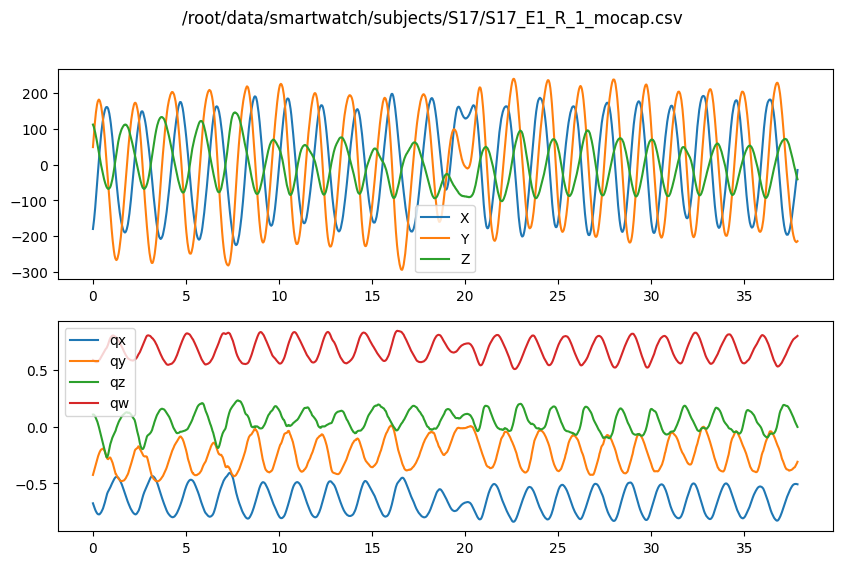

In [45]:
plot_file(fp)

In [46]:
s1_files = glob.glob("/root/data/smartwatch/subjects/S01/S01_E*_R_1_mocap.csv")
s1_files.sort()

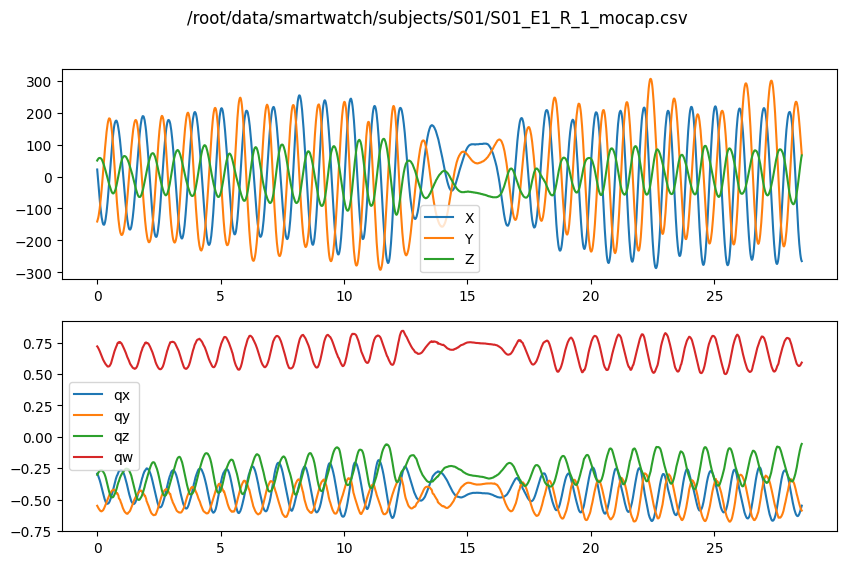

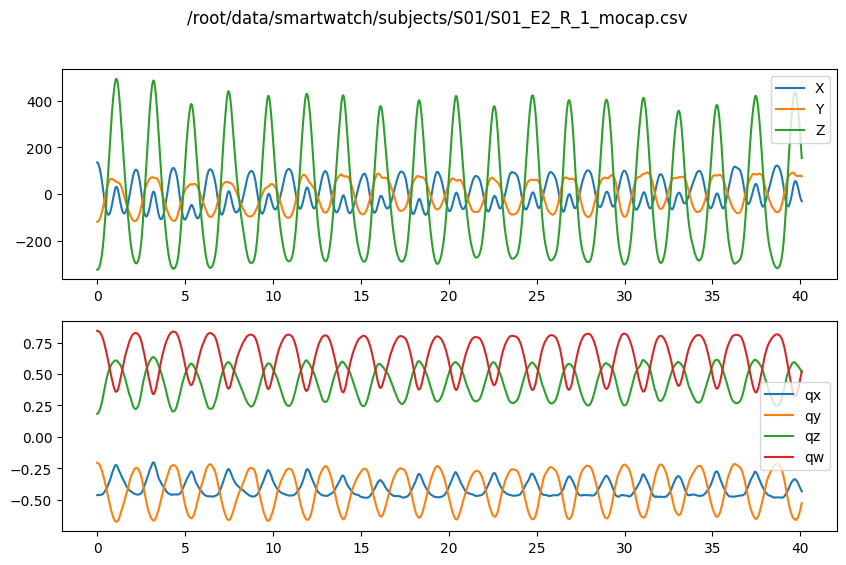

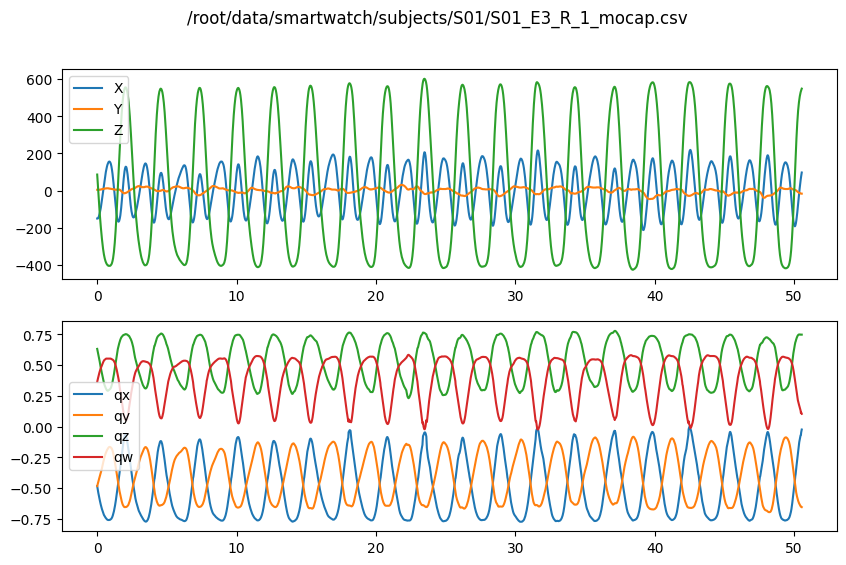

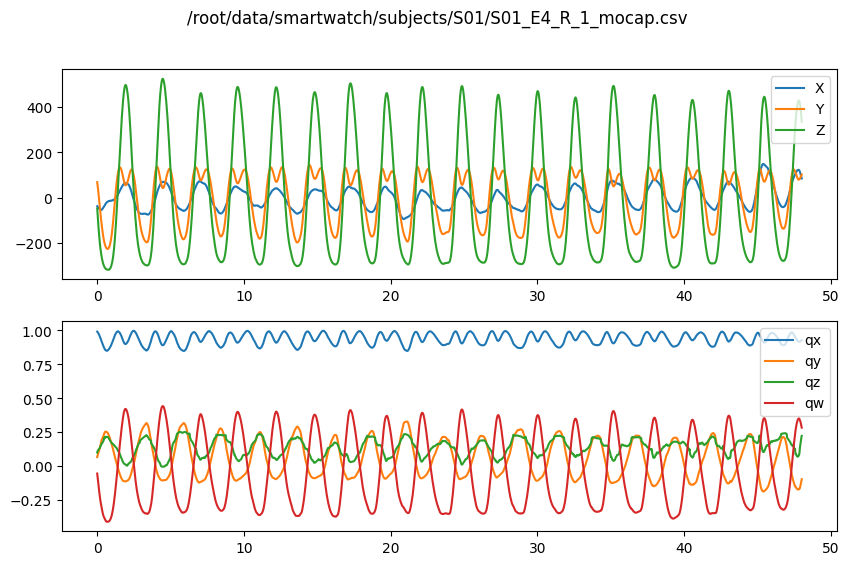

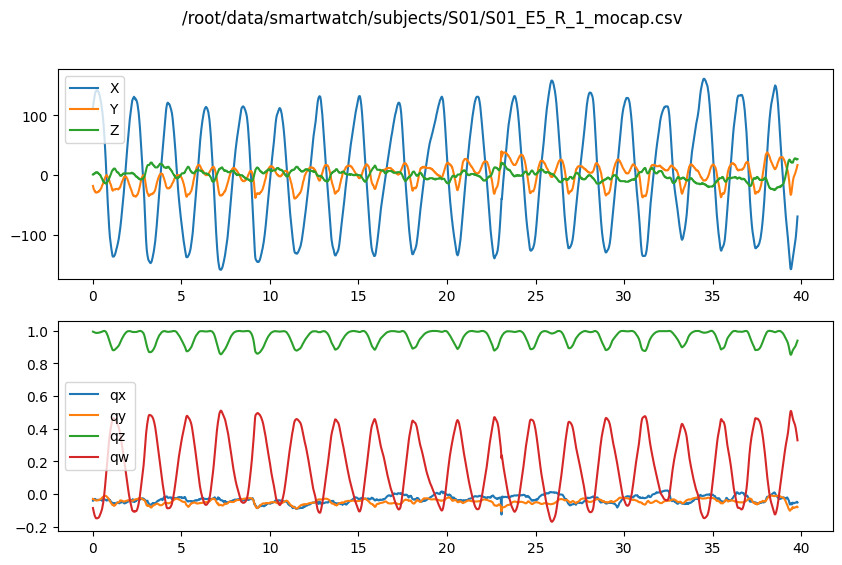

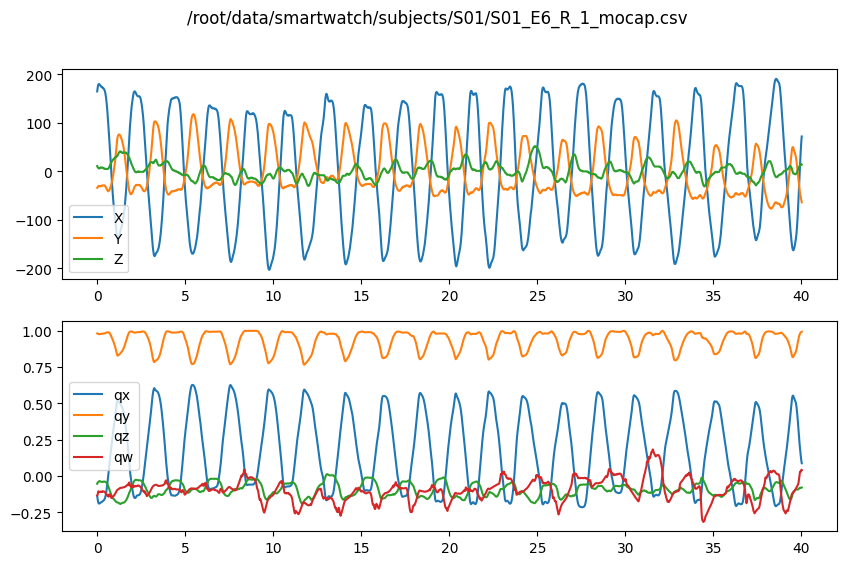

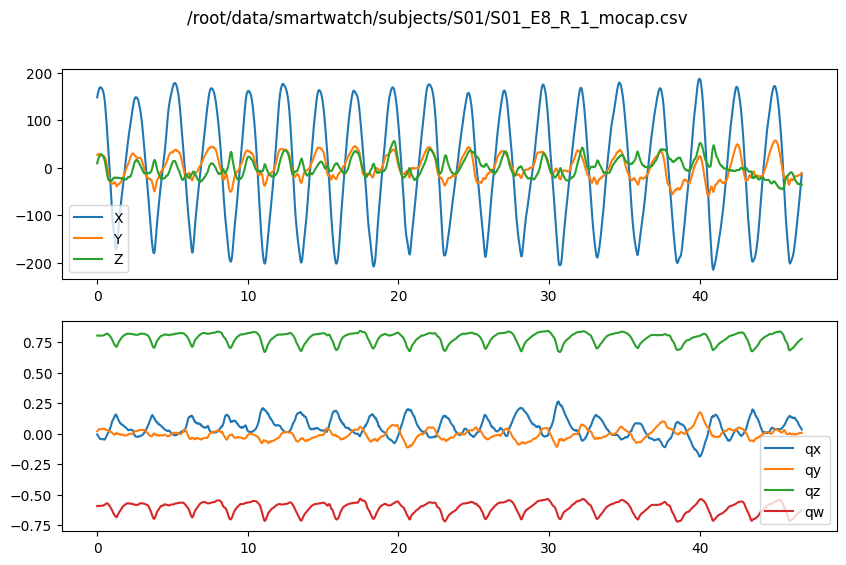

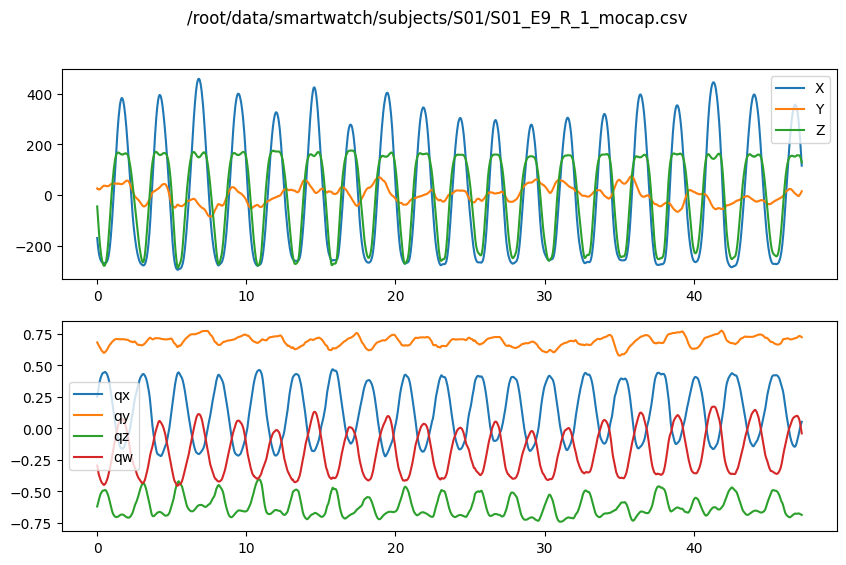

In [47]:
for file in s1_files:
    plot_file(file)

In [48]:
s2_files = glob.glob("/root/data/smartwatch/subjects/S02/S02_E*_R_1_mocap.csv")
s2_files.sort()

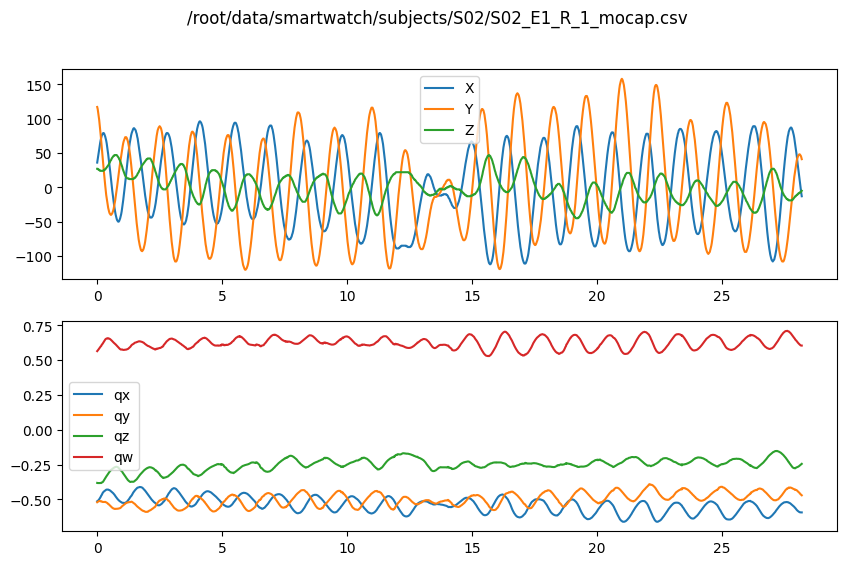

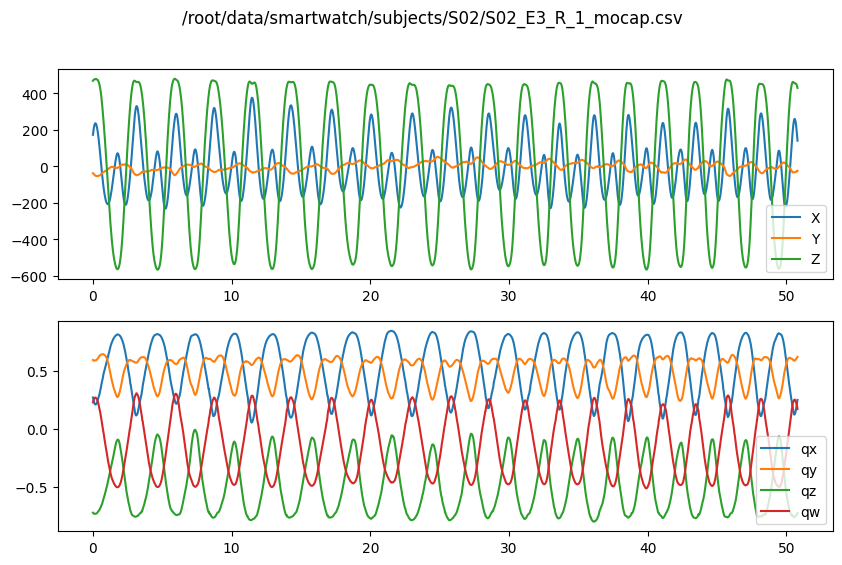

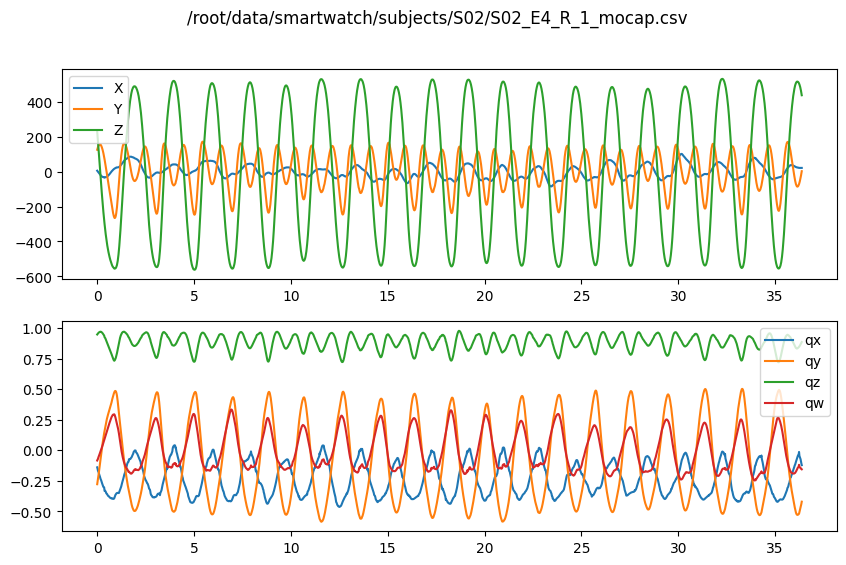

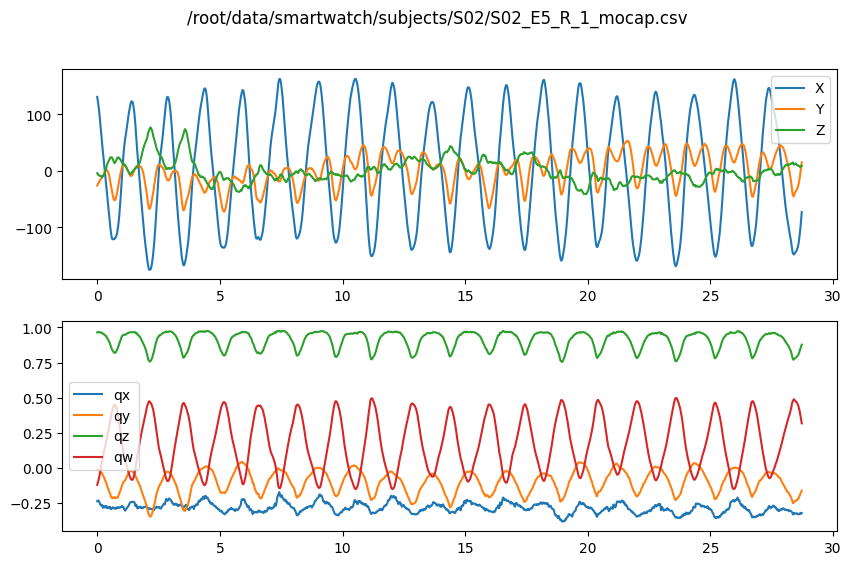

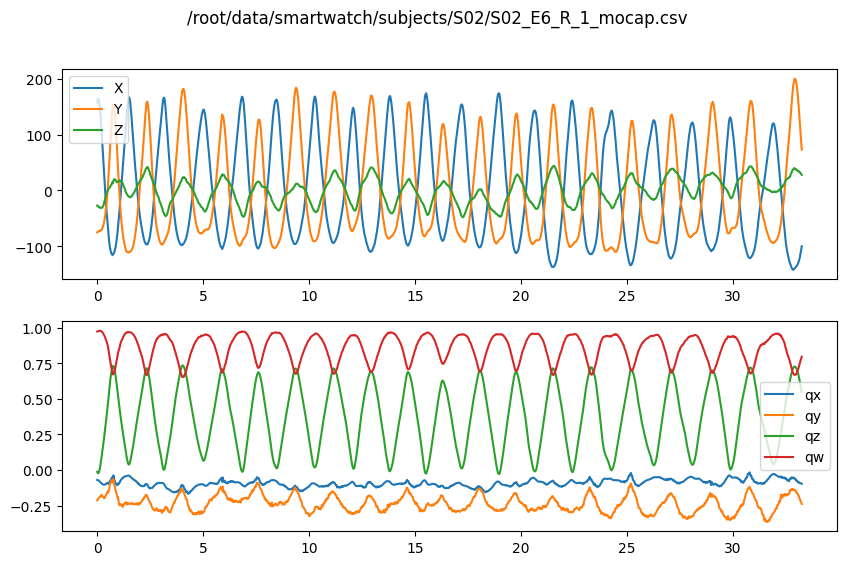

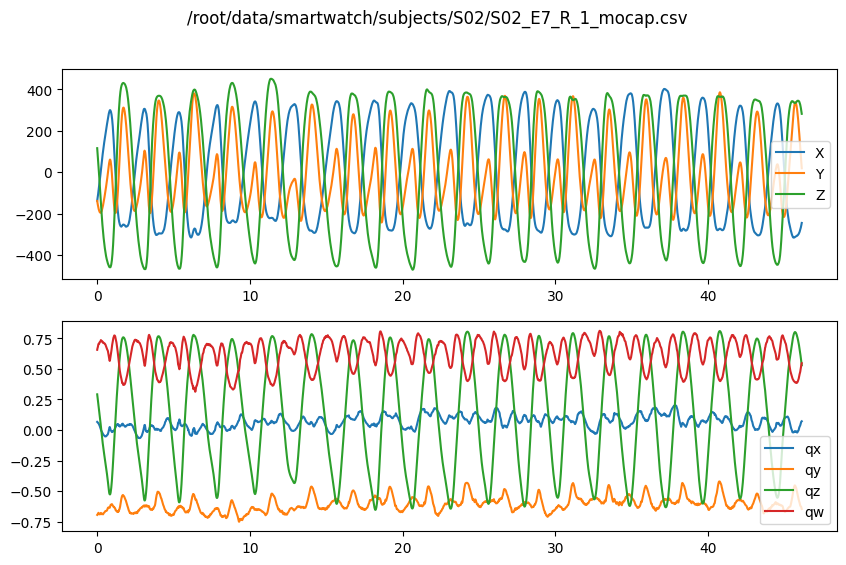

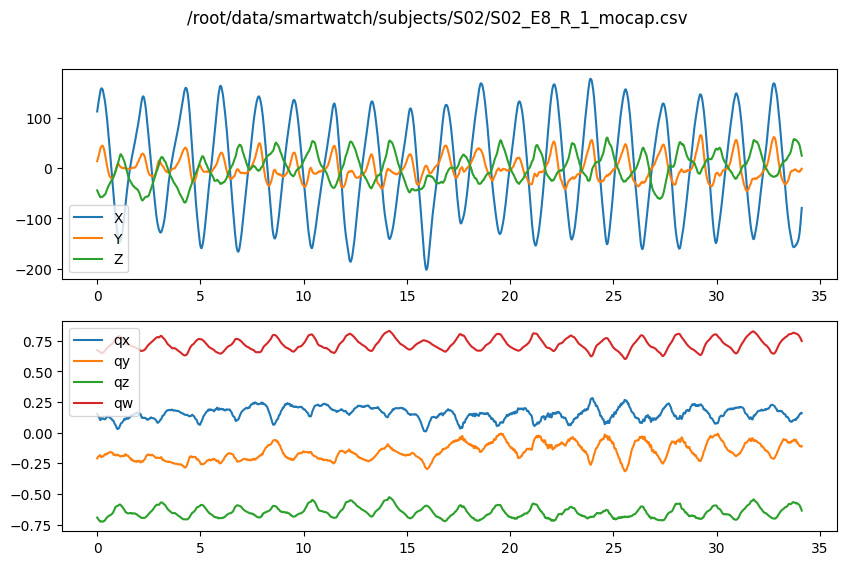

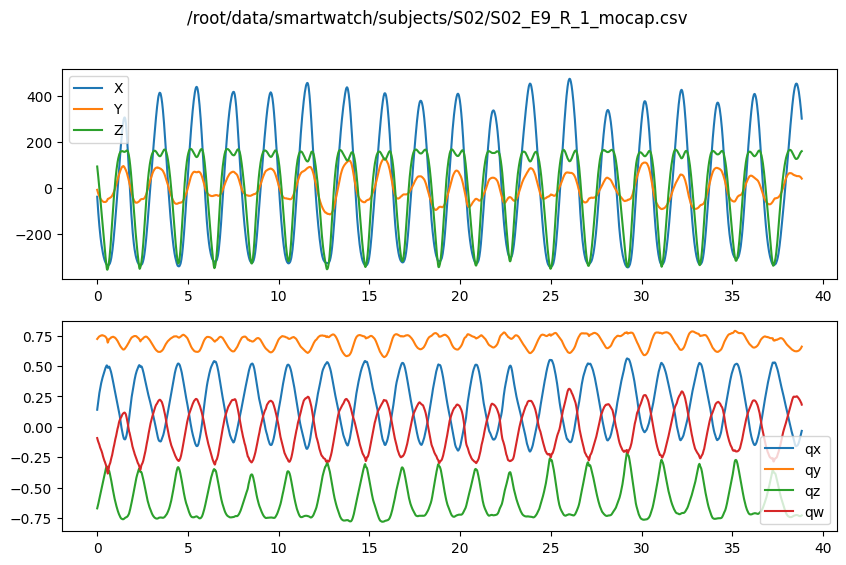

In [49]:
for file in s2_files:
    plot_file(file)